In [1]:
# For reloading modules
import importlib

# My modules config has to be imported first
import config as cfg
import datasets
import utils
import models
import train
import tester
import display as disp

import time
import datetime
import tensorflow as tf
import numpy as np
import sys

# Video and visualization stuff
import tqdm
import PIL.Image, PIL.ImageDraw

from IPython.display import Image, HTML, clear_output, Video
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter

import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

import matplotlib.pyplot as plt
from visdom import Visdom

In [2]:
""" ---- RELOAD MODULES ---- """
# only execute code if first cell has already been executed
# TODO does not reload settings...
if "importlib" in sys.modules:
  # can be executed instead of realoding the whole notebook
  importlib.reload(utils)
  importlib.reload(models)
  importlib.reload(datasets)
  importlib.reload(cfg)
  importlib.reload(train)
  importlib.reload(tester)
  importlib.reload(disp)
  print("Successfully reloaded modules")
else:
  print("Import Modules first, then reload :)")

Successfully reloaded modules


In [2]:
""" --- CREATE SW, DATA, MODEL AND TRAINER --- """

# Background options before creating the model (e.g. random seed/floatx)
utils.background_options()

# Create Data, Model, Trainer
train_sw, val_sw, test_sw = utils.get_summary_writers()
vis = None # Visdom()   # visdom.sh needs to be running
data_class = datasets.get_dataset_class()
data, data_seperator = data_class.dataset, data_class.seperator
model = models.get_model(train_sw)
# ca = models.CAModel(summary_writer=train_sw)
# trainer = train.Trainer(data["train"], data["val"], ca, vis, data_seperator)
trainer = train.get_trainer()(data["train"], data["val"], model, vis, data_seperator)

# Save and print configs
utils.save_cfg()
if cfg.MODEL.NAME == "NCA":
  trainer.ca.summary()
elif cfg.MODEL.NAME == "GANCA":
  trainer.g_model.ca.summary()
  trainer.d_model.summary()
print(utils.get_cfg_infos())

Creating Emoji Dataset
Successfully saved configs at:  logs/maybe/2021_06_03/11_13_58/
------------
Model: "dmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 40, 40, 16)]      0         
_________________________________________________________________
perceive (Conv2D)            (None, 40, 40, 128)       18560     
_________________________________________________________________
last_layer (Conv2D)          (None, 40, 40, 16)        2064      
Total params: 20,624
Trainable params: 20,624
Non-trainable params: 0
_________________________________________________________________
dmodel:  None
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 1)                 55937     
Total params: 55,937
Trainable params: 55,937
Non-t

In [3]:
""" LOAD PRETRAINED DISCRIMINATOR MODEL """
path = "models/2021/april/disc/simple/"
disc_model = tf.keras.models.load_model(path)
weights = disc_model.get_weights()


for i in range(len(disc_model.layers[0].layers) - 1):
  cur_weights = disc_model.layers[0].layers[i].get_weights()
  trainer.d_model.layers[0].layers[i].set_weights(cur_weights)

In [3]:
""" LOAD PRETRAINED CA FOR GENERATOR"""
# path = "models/2021/ganca/ca/microsoft_lost_of_faces/"
# path = "models/2021/april/number_emojis/faces_50_5k"
path = "models/2021/april/ganca/pretrained_5k_50_faces"
trainer.g_model.ca.load_weights(path + "/10kca")
# trainer.load_weights(path, model_name="ca")

(74, 592, 3)


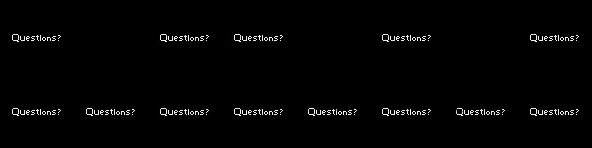

 r: 0 step: 5000, total_loss: 2.374 min: 0.637 max: 166500.078

In [3]:
# """ --- TRAINING ---"""
NUM_RUNS = 1
cfg.TRAIN.NUM_TRAINING_STEPS = 5000

# save_path = "models/2021/rationals/mc_faces_5k/"
layer_output_log = []
gradient_log = []
layer_weights_log = []

# writer has to be outside as inside the summary for weights are called
# TODO how to add val writer in here?
for e in range(NUM_RUNS):
  with train_sw.as_default():
    
    if e > 0:
      model = models.get_model(train_sw)
      trainer = train.get_trainer()(data["train"], data["val"], model, vis, data_seperator)
      
    for i in range(1, cfg.TRAIN.NUM_TRAINING_STEPS+1):
      x0, x_out, losses, grads, log = trainer.full_train_step(i)
      trainer.visualize(x0, x_out, losses, grads, e)

    # utils.save_model_and_plot(trainer, save_path, name=f"{e}")
    if cfg.EXTRA.LOG_LAYERS:
      gradient_log.append(grads)
      layer_output_log.append(log)
      layer_weights_log.append([layer.numpy() for layer in trainer.ca.weights])

        

In [4]:
vis = Visdom()
# vis.plotlyplot(disp.plot_ganca_loss(trainer.losses, return_plot=True))
vis.plotlyplot(disp.plot_train_and_val_loss(trainer.loss_log,trainer.val_loss_log,
                                            return_plot=True, y_range=(0,200)))

Setting up a new session...


'window_397b343b0e9c5c'

In [7]:
""" --- SAVE AND PLOT MODEL --- """
save_path = "models/2021/fun/very_big_wanca/600/"
utils.save_model_and_plot(trainer, save_path, name="")

Successfully saved figure at:  models/2021/fun/very_big_wanca/600/_fig.png
Successfully saved configs at:  models/2021/fun/very_big_wanca/600/


In [5]:
""" --- LOAD MODEL --- """
# TODO load model from currently selected configs
path = "models/2021/THESIS/faces_50_10k/wanca"
# TODO merge these two calls and normalize them 
# trainer.load_weights(path + "model")
trainer.load_weights(path)

Succesfully loaded ca from  models/2021/THESIS/faces_50_10k/wanca
Succesfully loaded disc from  models/2021/THESIS/faces_50_10k/wanca


In [ ]:
data_class = datasets.get_dataset_class()
data, data_seperator = data_class.dataset, data_class.seperator

In [7]:
""" ---- VIDEO -----"""
import IPython
importlib.reload(disp)
importlib.reload(utils)
importlib.reload(datasets)
# Bigger padding around img (cfg.WORLD.SIZE for standard size) 
# TODO define different sets to know where which images are
# x_img_list_1 = data[][:40]
# x_img_list_2 = x_train[40:]
# TODO add damaged part of dataset/maybe option to see clean image
# TODO function to plot all types of different data (based on seperator), one or several images one call
# x_big = datasets.add_padding(data["train"]["x"][101], cfg.DATA.GRID_SIZE + 0)[None, :]

plt.rcParams['figure.figsize'] = [16, 12]
# %matplotlib
include_y = True
keep_input = True
imgs_dict = data_class.get_all_img_types("val", idx_offset=0, max_num=27,
                                         random_idx=False, include_y=include_y)


# TODO when using extra final layer, this is not good
if cfg.MODEL.NAME == "NCA":
  vid_ca = trainer.ca
  tanh_layer = False
elif cfg.MODEL.NAME == "GANCA":
  vid_ca = trainer.g_model.ca

num_steps = cfg.WORLD.CA_STEP_RANGE[0] + 150
start = time.time()
disp.show_batch_run(imgs_dict, vid_ca, num_steps, only_alive_cells=False,
                    white_background=False, include_y=include_y, keep_input=keep_input,
                   better_video=True)
print("total", time.time() - start)
# print(imgs)
# assert False

# start = time.time()
# for key, value in imgs_dict.items():
  # TODO do as a single batch
  # vid = disp.show_simple_run(value[None,:], trainer.ca, cfg.WORLD.CA_STEP_RANGE[0] + 300 ,
#                             only_aleive_cells=False, white_background=False)
  # disp.show(vid)
# print("total2: ", time.time() - start)
  # plt.imshow(vid)
  # plt.show()
# Y image as start
# expanded_y = np.zeros_like(x_train[0:1])
# expanded_y[:,:,:,0:4] = y_train[0:1]

# Cut image as start
# x_cut = trainer.cut_x(expanded_y[:8])[0:1]

# Create and show video

# vis.video(videofile="./_autoplay.mp4")

total 2.076387882232666


In [7]:
# path = "emojis/activity/apple/american-football_1f3c8"
# Automatically load/list all self drawn emojis
import os
import icecream as ic
path = "self_drawn/"
setting = "canny" # or canny
path = path + setting + "/"
file_names = [path + name.split('.')[0] for name in os.listdir(path)]
number_of_samples = 18
keep_input=True

print(file_names)

print(cfg.WORLD.ENV_SIZE)
# starting from 1
hidden_info_idx = 20
hidden_info_idx += cfg.MODEL.CHANNEL_N - 1
x_dict = {}
# TODO this can sowas von ausgelagert werden in ne sinnvolle fkt
for img_path in file_names[:number_of_samples]:
  single_x = np.zeros((1,) + (cfg.DATA.TARGET_SIZE,) *2 + (cfg.MODEL.CHANNEL_N+ cfg.WORLD.ENV_SIZE,),
                      dtype=cfg.MODEL.FLOATX)
  emoji = datasets.Emoji(img_path, from_file=True)
  
  if setting == "adaptive_gaus":
    # print(f"{emoji.emoji_img.shape=}")
    single_x[:,:,:,:4] = emoji.emoji_img[None, :]
  elif setting == "canny":
    single_x[:,:,:,:4] = emoji.emoji_img[None, :]
    single_x[:,:,:,:4] = np.repeat(single_x[:,:,:,3:4], 4, axis=3)
  
  # TODO only when hidden information is available
  if cfg.WORLD.ENV_SIZE > 1:
    single_x[:,:,:,hidden_info_idx:hidden_info_idx+1] = 0.9
  
  # utils.save_img_to_file(single_x[0,:,:,:3], f"../../imgs/emojis/{img_path}.png")
  single_x = datasets.add_padding(single_x[0], cfg.DATA.GRID_SIZE)[None, :]
  single_x = np.array(single_x > 0.5, dtype=cfg.MODEL.FLOATX)
  x_dict[img_path] = single_x[0]

if cfg.MODEL.NAME=="GANCA":
  disp.show_batch_run(x_dict, trainer.g_model.ca, 200, keep_input=keep_input, better_video=True)
elif cfg.MODEL.NAME=="NCA":
  disp.show_batch_run(x_dict, trainer.ca, 200, keep_input=keep_input, better_video=True)

['self_drawn/canny/round_2', 'self_drawn/canny/perfect', 'self_drawn/canny/1', 'self_drawn/canny/round_thin_1', 'self_drawn/canny/round_1', 'self_drawn/canny/round_4', 'self_drawn/canny/round_3', 'self_drawn/canny/3', 'self_drawn/canny/thick_2', 'self_drawn/canny/big_3', 'self_drawn/canny/round_thin_3', 'self_drawn/canny/big_1', 'self_drawn/canny/2', 'self_drawn/canny/round_thin_2', 'self_drawn/canny/big_4', 'self_drawn/canny/4', 'self_drawn/canny/thick_1', 'self_drawn/canny/big_2', 'self_drawn/canny/5']
0


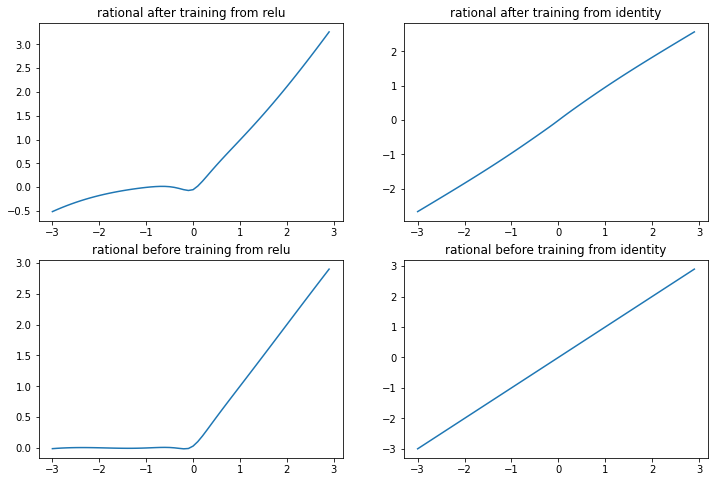

In [6]:
# vis = Visdom()
# vis.plotlyplot(disp.plot_ganca_loss(trainer.losses, return_plot=True))
inp = np.arange(-3,3,0.1, dtype="float32")
# out = trainer.ca.activations[1](inp)
from rational.keras import Rational

init_relu = Rational(approx_func='relu')
init_identity = Rational(approx_func='identity')

plt.rcParams['figure.figsize'] = [12, 8]
# %matplotlib qt
plt.subplot(221)
out1 = trainer.ca.activations[0](inp)
plt.title("rational after training from relu")
plt.plot(inp, out1)
# plt.show()
plt.subplot(222)
out2 = trainer.ca.activations[1](inp)
plt.title("rational after training from identity")
plt.plot(inp,out2)
plt.subplot(223)
plt.plot(inp, init_relu(inp))
plt.title("rational before training from relu")
plt.subplot(224)
plt.plot(inp, init_identity(inp))
plt.title("rational before training from identity")
plt.show()

In [26]:
ganca, real, fake, _ = trainer.get_train_batch()

In [ ]:
""" PRETRAIN DISCRIMINATOR MODEL """
disc_trainer = train.DiscTrainer(data["train"], data_seperator, model.disc_model)
disc_trainer.disc.save("models/april/disc/new/")

In [25]:
""" FRAME BY FRAME OUTPUT OF A SINGLE IMAGE """

input_img = data["train"]["x"][0]

%matplotlib qt
# plt.rcParams["figure.figsize"] = [12,8]
all_outs = []
x = input_img[None, :]
for i in range(60):
  x = trainer.ca(x)
  all_outs.append(np.clip(x[0], 0, 1))
  
show_idxs = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 59]

all_outs = np.stack(all_outs, axis=0)
for idx, i in enumerate(show_idxs):
  plt.subplot(1, len(show_idxs), idx+1)
  plt.axis('off')
  plt.imshow(all_outs[i, :, :, :3])

plt.subplots_adjust(wspace=0.05)
# plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


utils.mmm(fake_img[0, :, :, :3])=(-0.2764559, 0.22232142, 0.9999993)
(0.0, 0.21618709, 1.0)
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=58>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


utils.mmm(ca_out[0,:,:,:3])=(-0.25995684, 0.22175069, 0.99999905)


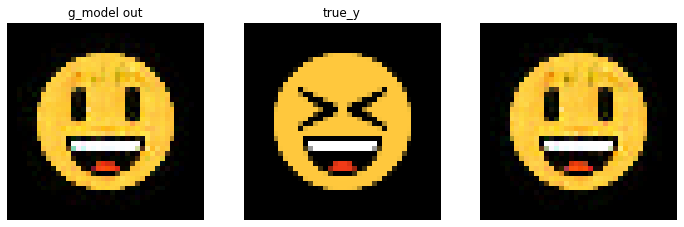

In [46]:
fake_img, gen_out = trainer.g_model(ganca[0], trainer.num_steps)

%matplotlib inline
plt.rcParams["figure.figsize"] = [12,8]
print(f"{utils.mmm(fake_img[0, :, :, :3])=}")
plt.subplot(131)
plt.title("g_model out")
plt.imshow(fake_img[0, :, :, :3])
plt.axis('off')

img2 = trainer.train_set["y"][900,:,:,:3]
print(utils.mmm(img2))
plt.subplot(132)
plt.title("true_y")
plt.imshow(img2)
plt.axis('off')


x = ganca[0]
print(trainer.num_steps)
all_outs = []
with disp.VideoWriter("_autoplay.mp4") as vid:
  for i in range(58):
    x = trainer.g_model.ca(x)
    ca_out = np.tanh(x)
    vid.add(ca_out[0,:,:,:3])
    
print(f"{utils.mmm(ca_out[0,:,:,:3])=}")
plt.subplot(133)
plt.imshow(ca_out[0, :, :, :3])
plt.axis('off')
plt.show()
run = disp.Video("./_autoplay.mp4", width= 240 * 1,
 height=240 * 1, html_attributes="autoplay controls", embed=True)
# print(key_list[batch_idx])
disp.show(run)

In [4]:
x = data["train"]["x"]
# invert colors, white background

with disp.VideoWriter("_autoplay.mp4") as vid:
  for i in range(100):
    x = trainer.ca(x)
    # vid.add(1-x[0,:,:,3:4] + x[0,:,:,:3])
    vid.add(1-x[0,:,:,:3])
    
# disp.show(vid)

In [ ]:
# path = "emojis/activity/apple/american-football_1f3c8"
# Automatically load/list all self drawn emojis
import os

path = "self_drawn/"
file_names = [path + name.split('.')[0] for name in os.listdir(path)]
print(file_names)

x_dict = {}
# TODO this can sowas von ausgelagert werden in ne sinnvolle fkt
for img_path in file_names:
  single_x = np.zeros((1,) + (cfg.DATA.TARGET_SIZE,) *2 + (cfg.MODEL.CHANNEL_N,), dtype=cfg.MODEL.FLOATX)
  emoji = datasets.Emoji(img_path, from_file=True)
  single_x[:,:,:,:4] = emoji.emoji_img[None, :]
  single_x[:,:,:,:4] = np.repeat(single_x[:,:,:,3:4], 4, axis=3)
  single_x = datasets.add_padding(single_x[0], cfg.DATA.GRID_SIZE)[None, :]
  single_x = np.array(single_x > 0.1, dtype=cfg.MODEL.FLOATX)
  x_dict[img_path] = single_x[0]
# single_x = 1 - single_x
# %matplotlib qt
print(utils.mmm(single_x))
plt.imshow(single_x[0,:,:,:3])
plt.show()

utils.save_img_to_file(single_x[0,:,:,:3], f"../../imgs/emojis/test.png")

disp.show_simple_run(single_x, trainer.ca, 200)

In [ ]:
# TODO combine with other visualization function
ganca_in_train, _ = trainer.get_input_samples(trainer.train_set["x"], 16)
fake_x_train, _ = trainer.get_fake_samples(ganca_in_train, 16, validation=True)
fake_x_train = np.clip(fake_x_train, 0, 1)
# print(fake_x_train.shape)

ganca_in_val, _ = trainer.get_input_samples(trainer.val_set["x"], 16)
fake_x_val, _ = trainer.get_fake_samples(ganca_in_val, 16)
fake_x_val = np.clip(fake_x_val, 0, 1)

plt.rcParams['figure.figsize'] = [12, 8]

for i in range(1,17):
  plt.subplot(4,4,i)
  plt.imshow(fake_x_train[i-1,:,:,:4])
  plt.axis('off')
plt.suptitle("Train imgs")
plt.show()

for i in range(1,17):
  plt.subplot(4,4,i)
  plt.imshow(fake_x_val[i-1,:,:,:4])
  plt.axis('off')
plt.suptitle("Val imgs")
plt.show()

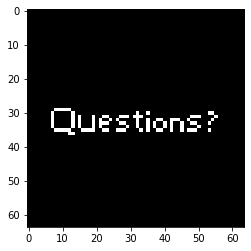

In [5]:
plt.imshow(data["train"]["y"][0,:,:,:3])
plt.show()

0
microsoft/face-savouring-delicious-food_1f60b_EDGES (40, 40, 16) (40, 40, 4)
(0, 67.411875, 201)


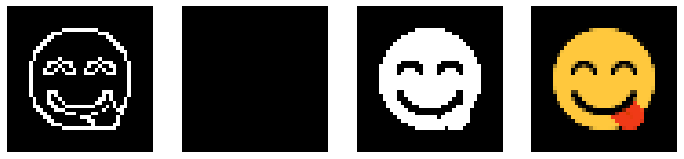

microsoft/face-palm_1f926_EDGES (40, 40, 16) (40, 40, 4)
(0, 46.881875, 216)


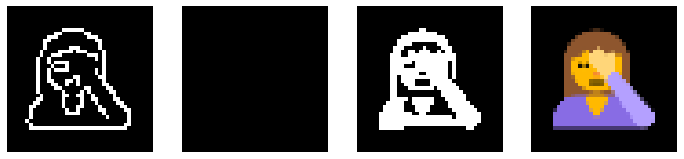

microsoft/smirking-face_1f60f_EDGES (40, 40, 16) (40, 40, 4)
(0, 66.92625, 201)


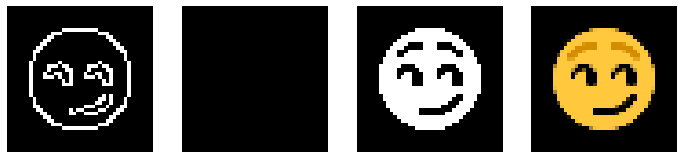

microsoft/face-with-monocle_1f9d0_EDGES (40, 40, 16) (40, 40, 4)
(0, 67.53, 210)


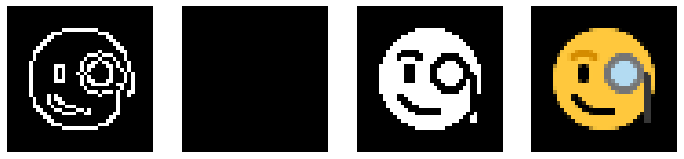

microsoft/confounded-face_1f616_EDGES (40, 40, 16) (40, 40, 4)
(0, 63.48625, 201)


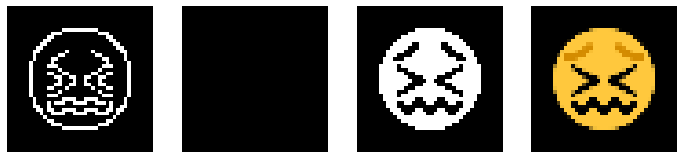

microsoft/neutral-face_1f610_EDGES (40, 40, 16) (40, 40, 4)
(0, 69.65, 201)


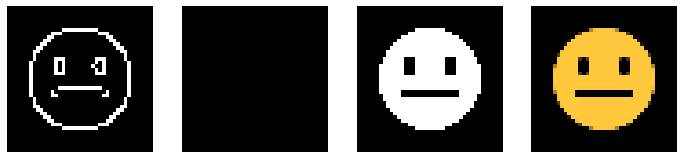

microsoft/kissing-cat-face-with-closed-eyes_1f63d_EDGES (40, 40, 16) (40, 40, 4)
(0, 66.955, 255)


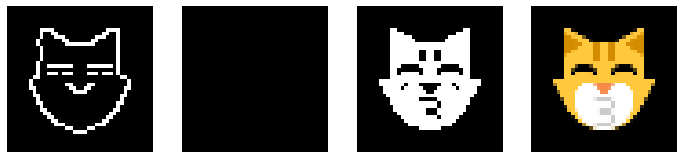

microsoft/drooling-face_1f924_EDGES (40, 40, 16) (40, 40, 4)
(0, 68.71, 201)


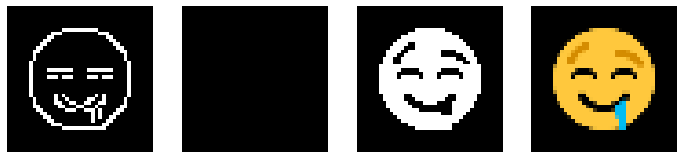

microsoft/smiling-face-with-open-mouth-and-smiling-eyes_1f604_EDGES (40, 40, 16) (40, 40, 4)
(0, 66.013125, 255)


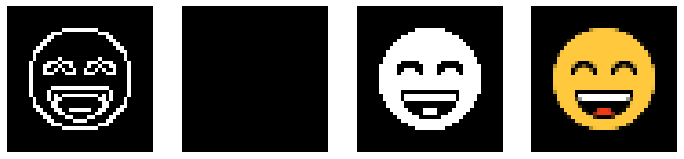

microsoft/face-with-stuck-out-tongue_1f61b_EDGES (40, 40, 16) (40, 40, 4)
(0, 63.373125, 201)


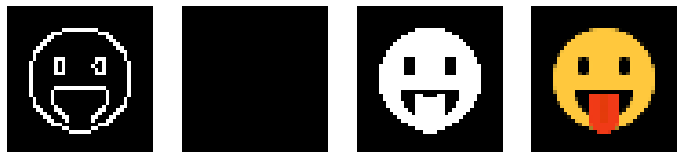

microsoft/sleeping-face_1f634_EDGES (40, 40, 16) (40, 40, 4)
(0, 64.2375, 201)


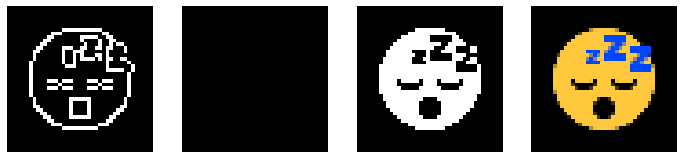

microsoft/loudly-crying-face_1f62d_EDGES (40, 40, 16) (40, 40, 4)
(0, 63.284375, 255)


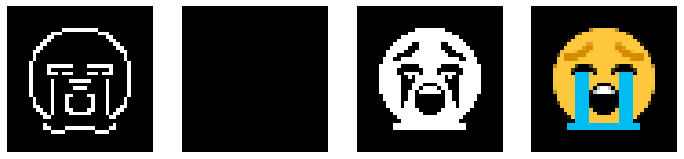

microsoft/cat-face-with-wry-smile_1f63c_EDGES (40, 40, 16) (40, 40, 4)
(0, 63.9, 255)


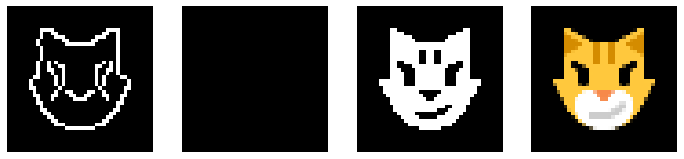

microsoft/grinning-face-with-star-eyes_1f929_EDGES (40, 40, 16) (40, 40, 4)
(0, 60.071875, 255)


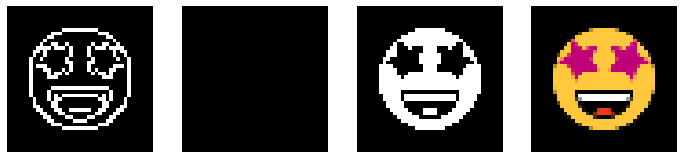

microsoft/worried-face_1f61f_EDGES (40, 40, 16) (40, 40, 4)
(0, 69.535, 201)


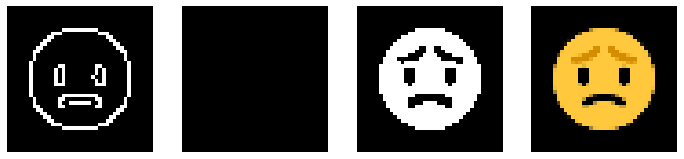

microsoft/sleepy-face_1f62a_EDGES (40, 40, 16) (40, 40, 4)
(0, 67.34625, 201)


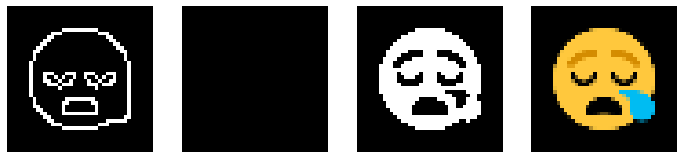

microsoft/anguished-face_1f627_EDGES (40, 40, 16) (40, 40, 4)
(0, 67.7225, 201)


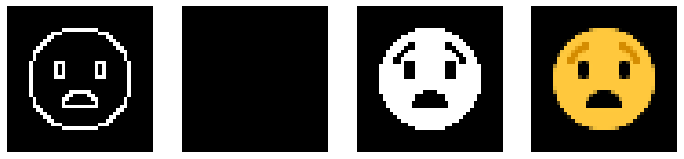

microsoft/fearful-face_1f628_EDGES (40, 40, 16) (40, 40, 4)
(0, 68.05125, 255)


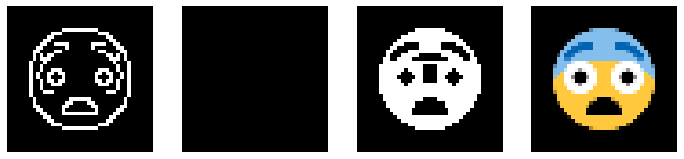

microsoft/grinning-face-with-one-large-and-one-small-eye_1f92a_EDGES (40, 40, 16) (40, 40, 4)
(0, 69.533125, 255)


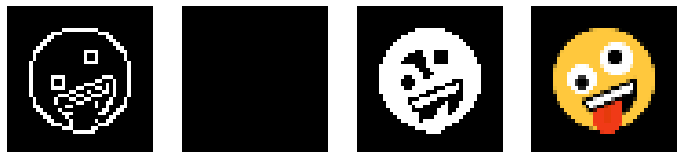

microsoft/face-with-one-eyebrow-raised_1f928_EDGES (40, 40, 16) (40, 40, 4)
(0, 71.410625, 201)


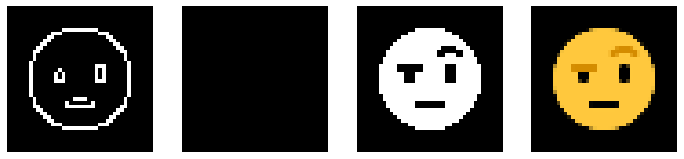

In [12]:
""" --- VISUALIZE DATASET ---- """

import cv2
out = data_class.get_all_img_types("val", 0, random_idx=True, include_y=True)

print(cv2.THRESH_BINARY)
plt.rcParams['figure.figsize'] = [12, 8]

def vis_dict(img_dict):
  for key, value in img_dict.items():
    print('/'.join(key.split('/')[2:]), value[0].shape, value[1].shape)
    plt.subplot(141)
    plt.axis('off')
    plt.imshow(value[0][:,:,:3])
    
    
    plt.subplot(142)
    plt.axis('off')
    rgb_img = value[1][:,:,:3] * value[1][:,:,3:4]
    gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
    gray_img = np.uint8(255 * gray_img)
    thresh, edges = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # plt.imshow(edges, cmap="gray")
    # Showing hidden information
    plt.imshow(value[0][:,:,4:7])
        
    plt.subplot(143)
    plt.axis('off')
     
    print(utils.mmm(gray_img))
    #  cv2.THRESH_BINARY | cv2.THRESH_OTSU for automatic threshold (not suuper good)
    # thresh, binary = cv2.threshold(gray_img, 145, 255, cv2.THRESH_BINARY)
    edges = cv2.adaptiveThreshold(gray_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,15,0)
    plt.imshow(edges, cmap="gray")
    
    plt.subplot(144) 
    plt.axis('off')
    plt.imshow(rgb_img)
    plt.show()
    
    # Enable if you want to save images to file
    name = key.split('/')[-2] + "_" + key.split('/')[-1]
    # utils.save_img_to_file(value[0][:,:,:3], f"../../imgs/emojis/{name}_gray.png")
    # utils.save_img_to_file(value[1][:,:,:3], f"../../imgs/emojis/{name}_rgb.png")

vis_dict(out)

In [ ]:
imgs_dict = data_class.get_all_img_types("val", idx_offset=0, random_idx=False)

num_steps = cfg.WORLD.CA_STEP_RANGE[0] + 150

# disp.show_batch_run(imgs_dict, trainer.ca, num_steps, only_alive_cells=False, white_background=False)

x_dict = imgs_dict
ca = trainer.ca
x = []
key_list = []
for key, value in x_dict.items():
  x.append(value)
  key_list.append(key)
x = np.stack(x, axis=0)

final_arr = np.empty([num_steps] + [40*7, 40*7, 3])
full_step_array = np.empty([num_steps] + [x.shape[0] - 1] + [x.shape[1]] + [x.shape[2]] + [3])
print(full_step_array.shape)  
print(final_arr.shape)
# assert False

for i in range(num_steps):
  res = disp.rgba_to_rgb(ca.classify(x), white_background=False)
  # only 49 as 7by7
  res = res[:49]
  full_step_array[i] = res
  x = ca(x)

j = -1
for i in range(full_step_array.shape[1]):
  if i % 7 == 0:
    j += 1
  final_arr[:, ((i%7)*40):((i%7)*40) + 40, j*40:j*40 + 40] = full_step_array[:,i]
  
# final_arr = np.reshape(full_step_array, (200, 280, 280, 3))
print(final_arr.shape)

with disp.VideoWriter("_autoplay.mp4") as vid:
  for i in range(num_steps):
    vid.add(final_arr[i])
run = Video("./_autoplay.mp4", width=720, height=720, html_attributes="autoplay controls", embed=True)
disp.show(run)
# 40*7 * 40*7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


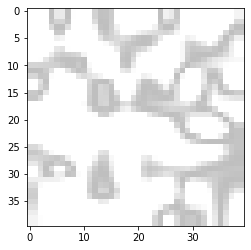

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


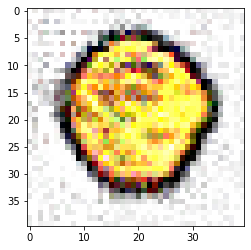

In [37]:
# Visuialize with latent dim input
%matplotlib inline
num_rows, num_cols = 5,5
num_imgs = num_rows * num_cols
input_latent = np.random.normal(size=(num_imgs, 100)).astype(cfg.MODEL.FLOATX)

img = np.reshape(input_latent[5], (10,10))
img = trainer.g_model.prep_input(input_latent)[0]
plt.imshow(img[:,:,:4])
plt.show()

out, fake_img = trainer.g_model(input_latent,50)
plt.imshow(trainer.g_model.prepare_output(out)[0])
plt.show()

In [8]:
# input_img = data["train"]["x"][0:1]
num_rows, num_cols = 5,5
num_imgs = num_rows * num_cols
input_latent = np.random.normal(size=(num_imgs, 100))
num_steps = 70
# num_steps = tf.Variable(1, dtype=tf.int32, trainable=False)
# trainer.num_steps.assign(50)

fake_img, gen_out = trainer.ganca.generator(input_latent, num_steps)

%matplotlib qt
#%matplotlib inline
for i in range(num_rows):
  for j in range(num_cols):
    plt.subplot(num_rows, num_cols, i*5 + j + 1)
    img = fake_img[i*5 + j]
    img = np.clip(img,0,1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [3]:
import cv2
import numpy as np
# Testing edge detection on higher res images

# %matplotlib inline
%matplotlib qt
path = "emojis/people/apple/"
emoji_str = path + "astronaut_1f9d1-200d-1f680"
img = np.array(PIL.Image.open(emoji_str + ".png"))
# img = img / 255.
print(utils.mmm(img))
plt.subplot(221)
plt.imshow(img)
plt.axis('off')
plt.subplot(222)
# img = img[:,:,:3] * img[:,:,3:4]
# img = img[:,:,:3]
# gray_img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
# gray_img = img[:,:,:3] * img[:,:,3:4]
# gray_img = img[:,:,:3] * (img[:,:,3:4]/255.)
rgb_img = np.uint8(img[:,:,:3] * (img[:,:,3:4] / 255.))
gray_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY)
# print(utils.mmm(gray_img))
small_img = cv2.resize(gray_img, (80,80))
small_img = cv2.resize(small_img, (40,40))
big_edges = cv2.Canny(small_img,250,500)
thresh, big_edges = cv2.threshold(big_edges, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# plt.imshow(datasets.get_gray_edge_image()
plt.imshow(big_edges, cmap="gray")
plt.axis('off')
plt.subplot(223)
plt.axis('off')
edges = cv2.Canny(gray_img,250,500)
plt.imshow(edges, cmap="gray")

plt.subplot(224)
plt.axis('off')
edges = cv2.Canny(gray_img,250,500)
edges_small = cv2.resize(edges, (80,80))
edges_small = cv2.resize(edges_small, (40,40))
thresh, edges_small = cv2.threshold(edges_small, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
plt.imshow(edges_small, cmap="gray")
plt.show()

(0, 126.14529513888888, 255)


In [ ]:
# steps:
# show example image
# show edges of example image
# get all images, select a random set from these
# crop images to same size/throw away images that are too small?

# add images into faces dataset, to be able to be called
# write abstract class?

import cv2
import os

num_targets = 10

file_names = os.listdir("faces_dataset/cropped/")
print(len(file_names))
random_idx = np.random.choice(range(len(file_names)), size=num_targets, replace=False)
random_files = [file_names[i] for i in random_idx]

# cv2.IMREAD_COLOR
# without alpha channel!


# This adds alpha channel, where each value is 1 (255). Maybbe possible to remove background by looking for
# 99% white pixels and declaring them as bg? But sounds tedious...
# Alpha channel all 1 means all cells will be alive from the getgo
# nevermind, as I will use the edges as input
# print(utils.mmm(img[:,:,3]))

def get_face_from_name(name):
  # Todo alpha channel will be only 1s
  img = cv2.imread(f"faces_dataset/cropped/{name}", cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
  print("dimensions ", img.shape)
  img = cv2.resize(img, (64,64))
  print("resized:", img.shape)
  return img
  
  
def face_to_edges(img):
  gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  edges = cv2.Canny(gray_img,100,200)
  edges = np.repeat(edges[:,:,None], 4, axis=2)
  edges = edges.astype(cfg.MODEL.FLOATX) / 255.
  return edges


for file_name in random_files:
  img = get_face_from_name(file_name)
  edge_img = face_to_edges(img)
  plt.subplot(121)
  plt.imshow(img)
  plt.subplot(122)
  plt.imshow(disp.rgba_to_rgb(edge_img))
  plt.show()
  
assert False
  
plt.subplot(221)
plt.imshow(img)
plt.subplot(222)
plt.imshow(disp.rgba_to_rgb(edges))
# print(img)
disp.imshow(edges)

em = datasets.Emoji("lizard")
plt.subplot(223)
plt.imshow(em.emoji_img)
plt.subplot(224)
plt.imshow(disp.rgba_to_rgb(em.get_gray_edge_image()))
plt.show()

In [ ]:
import cv2
# plt.rcParams['figure.figsize'] = [40, 20]
# Canny testing
def get_gray_edge_image(img, canny1, canny2):
  """ turns input image into edge image """
  # will expect a color image, will return a color image 
  img[:,:,:3] *= img[:,:,3:4]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = np.uint8(255 * img)
  edges = cv2.Canny(img,canny1,canny2, 3)
  edges = np.repeat(edges[:,:,None], 4, axis=2)
  edges = edges.astype(cfg.MODEL.FLOATX) / 255.
  return edges

# %matplotlib inline
img = out["emojis/people/twitter/grinning-face_1f600_EDGES"][1]
plt.imshow(img[:,:,:3] * img[:,:,3:4])
plt.axis('off')
plt.show()

%matplotlib qt
for j_idx, j in enumerate(np.linspace(-0,1000,5)):
  for i_idx, i in enumerate(np.linspace(0,1000,5)):
    edges = get_gray_edge_image(img, j, i)
    plt.subplot(5,5,i_idx + j_idx*5 + 1)
    plt.title(f"{j}/{i}")
    plt.axis('off')
    plt.imshow(edges[:,:,:3])


plt.tight_layout()
plt.show()


In [ ]:
importlib.reload(datasets)
len(datasets.emoji_dict)

In [ ]:
""" --- PLOT LOSS OVER TIME SINGLE RUN --- """
x = trainer.x_train[0:1]
y = trainer.y_train[0]
number_of_steps = cfg.WORLD.CA_STEP_RANGE[1] + 150

tester.plot_loss_over_time(x, y, trainer.ca,
                           trainer.individual_l2_loss, number_of_steps)

In [ ]:
# OLD, just to keep somewhere
# """ --- TRAINING ---"""
NUM_RUNS = 1
cfg.TRAIN.NUM_TRAINING_STEPS = 100

layer_output_log = []
gradient_log = []
layer_weights_log = []

# writer has to be outside as inside the summary for weights are called
# TODO how to add val writer in here?
with train_sw.as_default():
  for e in range(NUM_RUNS):
    if e > 0:
      ca = models.CAModel()
      trainer = train.Trainer(x_train, y_train, ca, vis)

    for i in range(1, cfg.TRAIN.NUM_TRAINING_STEPS+1):
      x0, x_out, losses, grads, log = trainer.full_train_step(i)
      trainer.visualize(x0, x_out, losses, grads, e)
      
      if cfg.EXTRA.LOG_LAYERS:
        gradient_log.append(grads)
        layer_output_log.append(log)
        layer_weights_log.append([layer.numpy() for layer in trainer.ca.weights])
        
        

In [ ]:
# vis = Visdom()
plot = disp.plot_losses(trainer.loss_log, return_plot=True)
# plot.show()
disp.visdom_plotly(vis, plot)

In [ ]:
"""--- DEBUGGING --- """
train_step = 9
ca_step = 0
layer = 0  # 0-12
batch = 0

# layer used for gradient or weights
trainable_layer = 0

# Plot input Layer
if False:
  infos = [train_step, ca_step, layer, batch]
  disp.plot_input_layer(layer_output_log[train_step][ca_step][layer][batch], infos=infos)

# Simple print of min mean max of full log
if False:
  for i in range(len(layer_output_log[train_step])):
    ca_step = i
    print(i, utils.mmm(layer_output_log[train_step][ca_step][layer][batch,:,:]))
    
    
# Simple print of gradient log
if False:
  print(utils.shape(gradient_log[trainable_layer]))
  for i in range(len(gradient_log)):
    print(i, utils.mmm(gradient_log[i][trainable_layer]))

if False:
  df = layer_weights_log[train_step][trainable_layer].flatten()
  fig = px.histogram(x=df, marginal="box", title=f"step:{train_step}, layer:{trainable_layer}")
  fig.show()

In [ ]:
e = datasets.Emoji("heavy_check_mark")
e.save_to_file()
edges = e.get_gray_edge_image()
utils.save_img_to_file(edges, "heavy_check_mark_edges.png")

In [ ]:
# plot weight distribution of layers:


# print(utils.shape(layer_weights_log[train_step][trainable_layer]))
# print(utils.mmm(layer_weights_log[train_step][trainable_layer]))
# utils.shape(trainer.ca.weights[0])
# train_step = 10
# trainable_layer = 0

# resulting behavior sigmoid vs clipping activation function
# likely because of the sigmoids tendency for 0.5 for 0, the gradient is motivated
# to shift all values a little bit higher. Which is why the layers have a positive mean shift
# but it does not explain the sudden explosion in values... 
train_steps = [0,5,6,7,8,9,10]
for layer in range(6):
  fig = go.Figure()
  for step in train_steps:
    fig.add_trace(go.Box(x=layer_weights_log[step][layer].flatten(), name=f"Step {step}"))
  fig.layout.title = f"Layer {layer}"
  fig.show()

In [ ]:
# plot = px.imshow(layer_output_log[2][30][0][0,:,:,1].numpy())
# plot.show()

train_step = 9

fig = go.Figure(
    data=[go.Heatmap(z=layer_output_log[train_step][0][0][0,:,:,0].numpy())],
    layout=go.Layout(
        title="Step 0",
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(label="Play",
                          method="animate",
                          args=[None])])]
    ),
    frames=[go.Frame(data=[go.Heatmap(z=layer_output_log[train_step][i][0][0,:,:,0].numpy())],
                      layout=go.Layout(title_text=f"Step {i}"))
            for i in range(len(layer_output_log[train_step]))]
)

fig.show()

In [ ]:
""" --- PLOTLY RENDERER --- """
print(pio.renderers)
pio.renderers.default = "notebook_connected"

In [ ]:
""" PLOTS MMM FOR OUTPUT ONLY """
x, _ = trainer.get_new_emoji_x_y()
tester.plot_min_max_mean_simple(x, trainer.ca, steps=200)


In [ ]:
""" --- PLOTS MMM FOR ALL LAYERS --- """
# only works if cfg.EXTRA.LOG_LAYERS is enabled
x_in = trainer.x_train[0:8]
tester.get_min_max_mean_all_layers(x_in, trainer.ca, steps=200)

In [ ]:
""" ---- TENSORBOARD ---- """
# Show model in tensorboard (training is irrelevant, but needed for plots)

y_in = np.zeros_like(trainer.x_train)
y_in[:,:,:,0:4] = trainer.y_train
tb_callback = tf.keras.callbacks.TensorBoard(log_dir="test/")
opti = tf.keras.optimizers.Adam(learning_rate=0.0000001)
ca.compile(optimizer=opti, loss='mse', metrics=["accuracy"])
ca.fit(trainer.x_train, y_in, batch_size=8, epochs=8, callbacks=tb_callback)

In [ ]:
""" --- PLOT EXECUTION TIME --- """
disp.plot_execution_time()